In [25]:
import sys
sys.path.append('../')

In [26]:
from dataset import DetectionDataset
from utils import plot_images
from default_boxes import *
from utils import xywh2xyxy, draw_rectangles, images_with_rectangles, xyxy2xywh
import matplotlib.pyplot as plt
from iou import calculate_iou

##  MNIST 데이터 다운로드 

In [27]:
# get sample image and object coordinates 
trainset = DetectionDataset(data_type='train')
gt_img, gt_info = trainset[0]
gt_coords = gt_info.iloc[:, 1:5].values
gt_coords = xywh2xyxy(gt_coords)
gt_labels = gt_info.iloc[:, -1].values

## Default boxes 생성

In [28]:
fmap = tf.constant(shape=(2, 8, 8, 2), value=1)
h, w = fmap.get_shape()[1:3]
n_layer = 11
paddings = ['SAME'] * n_layer
strides = [1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2]
kernel_sizes = [3] * n_layer
center_xy = original_rectangle_coords((h, w), kernel_sizes, strides, paddings)[:, :2]

# get w, h
scales = [30]
ratios = [(1, 1),
          (1.5, 0.5),
          (1.2, 0.8),
          (0.8, 1.2),
          (1.4, 1.4)]

# 적용할 default box 의 크기 
boxes = generate_default_boxes(scales, ratios)

# Get default boxes over feature map
default_boxes = tiling_default_boxes(center_xy, boxes)
default_boxes = xywh2xyxy(default_boxes)

## Matching Policy
 - default boxes 중 어떤 default box 을 학습에 사용할지 결정합니다. 
     - 이미지 한장에 대해 수행합니다.
     - default boxes 중 ground turth 와 IOU 가 50 겹쳐지는 default box 만 학습에 사용합니다. 
     - 하나의 default box에 복수개의 박스가 겹친다면 IOU가 가장 높은 데이터를 정답 데이터로 설정 합니다.
     - background class 는 0, 0, 0, 0 으로 설정합니다.  
     - ground truth 중 IOU가 특정 threshold 로 겹치는 default boxes 가 하나도 없다면 

In [29]:
# default boxes 
default_boxes = default_boxes.reshape(-1, 4)

# ground truth coordinates(x1, y1, x2, y2), shape = (N_obj, 4)
gt_coords = gt_coords.reshape(-1, 4)

# 각 obj 별 iou 을 구합니다. shape = (N_default_boxes, N_obj) 
ious = calculate_iou(xyxy2xywh(default_boxes), xyxy2xywh(gt_coords))

In [30]:
# iou 중 가장 overlay 비율이 큰 class을 선택합니다. 
# shape = (N_default_boxes, )
max_overlay_cls = np.argmax(ious, axis=-1)

# 모든 obj 에 대해 iou 가 0.5 이하이면 background class, -1로 지정합니다. 
background_mask = np.all(ious < 0.5, axis=-1)
max_overlay_cls[background_mask] = -1

# 기존의 정답 데이터에 [0, 0, 0, 0] 을 추가합니다. 
gt_with_bg = np.concatenate([gt_coords, np.array([[0, 0, 0, 0]])], axis=0)

# 각 default boxes에 해당하는 ground truth 의 좌표값을 가져옵니다. 
true_reg = gt_with_bg[max_overlay_cls]

In [31]:
# iou 가 0.5 이상 겹치는 iou 을 가져옵니다. 
pos_ious_max = np.max(ious[np.any(ious > 0.5, axis=-1)], axis=-1)

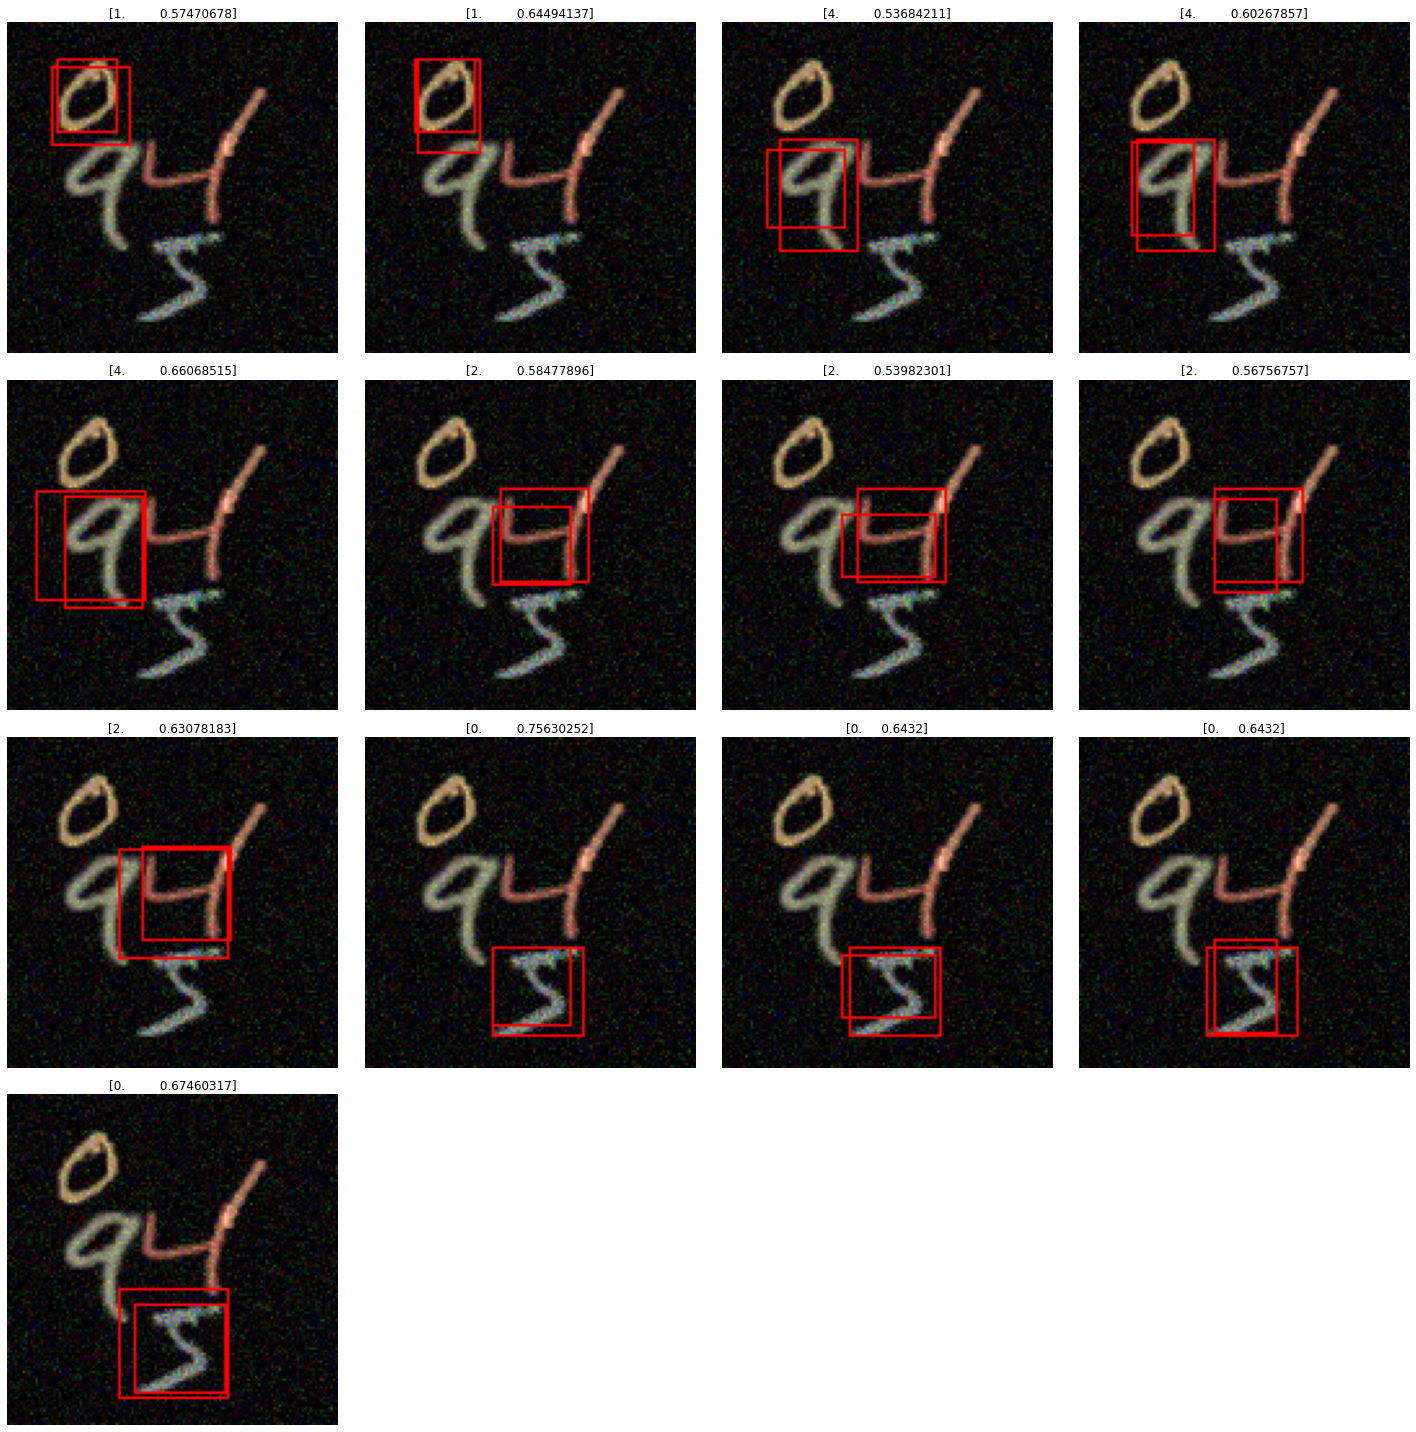

In [32]:
# visualization
pos_mask = np.all(true_reg, axis=-1)

# 객체를 포착한 class 와 coordinates만 가져옵니다
pos_true_cls = max_overlay_cls[pos_mask]
pos_true_reg = true_reg[pos_mask].reshape(-1, 1, 4)
pos_dflt_reg = default_boxes[pos_mask].reshape(-1, 1, 4)

# 각 default box 별 ground truth bbox. 이미지를 시각화해 보여줍니다. 
sample_imgs = [gt_img*255]*len(pos_true_reg)
pos_boxes = np.concatenate([pos_true_reg, pos_dflt_reg], axis=1)
rected_imgs = images_with_rectangles(sample_imgs, pos_boxes)
title_info = np.stack([pos_true_cls, pos_ious_max], axis=-1)
plot_images(rected_imgs, title_info)

### 모델에 입력할 우l치 정보 생성
- bounding box 와 matching 되는 ground truth 의 bounding box 생성

In [19]:
model_true_bboxes = gt_with_bg[max_overlay_cls]